<a href="https://colab.research.google.com/github/MarcusBae/AIFFEL_quest_eng/blob/main/26_01_26_kaggle_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Spaceship Titanic

채점 기준 (총 5점)
- 제출 : 1점
- 데이터 전처리 및 시각화 : 1점
  - 전처리 수행에 대한 논리적 근거를 함께 서술.
  - 데이터 시각화를 통해 알게된 내용을 함께 서술.
- 모델 학습 성공 및 결과 분석 인사이트 도출 : 1점
- 정확도 80.5% 달성 : 1점
- 보고서 양식 : 1점
- 개요, 목차, 주석 및 의견, summary, 회고, reference 등


* 전략
  * 이미 해결한 원본을 따라가 보고 이해한다.

* 참조  
  * https://velog.io/@ckh0824/Spaceship-Titanic-kaggle
  
* 개선점
  * train, test 데이터 전처리 코드의 중복 -> 하나로 처리할 것
   
* 결과

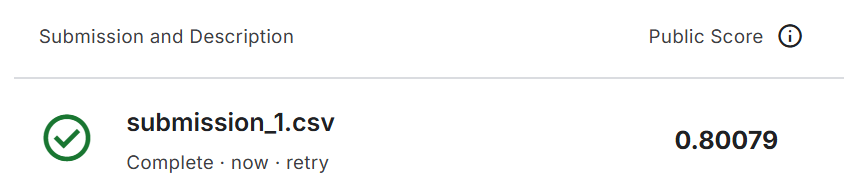

1. IMPORT
2. 데이터 로드

In [ ]:
#------------------------------------------------------------------------------
# kaggle : Spaceship Titanic - 1. 원본 feature 사용
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# 1. IMPORT
#------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

#------------------------------------------------------------------------------
# 2. 데이터 로드
#------------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/kaggle/spaceship_titanic"

train_data = pd.read_csv(f"{DATA_PATH}/train.csv")
test_data = pd.read_csv(f"{DATA_PATH}/test.csv")
sample_submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (8693, 14)
Test shape: (4277, 13)


 3. TRAIN 전처리


* Id, Transported 제외하고 결측지 있음 확인했다.
* 각 feature의 type을 확인했다.

In [ ]:
train_data.isna().sum()

,0
PassengerId,0
HomePlanet,201
CryoSleep,217
Cabin,199
Destination,182
Age,179
VIP,203
RoomService,181
FoodCourt,183
ShoppingMall,208


* train_datad의 수치형 데이터에는 Age 제외하면 하위 25%. 50% 값이 0이다.

In [ ]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


* train_data의 범주형 데이터를 확인한다. - 종류와 최빈값 확인

In [ ]:
train_data.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,False,Ankalik Nateansive
freq,1,4602,5439,8,5915,8291,2


* train_data의 수치형 데이터 확인
  * 평균이 낮고 대부분 0에 가깝다

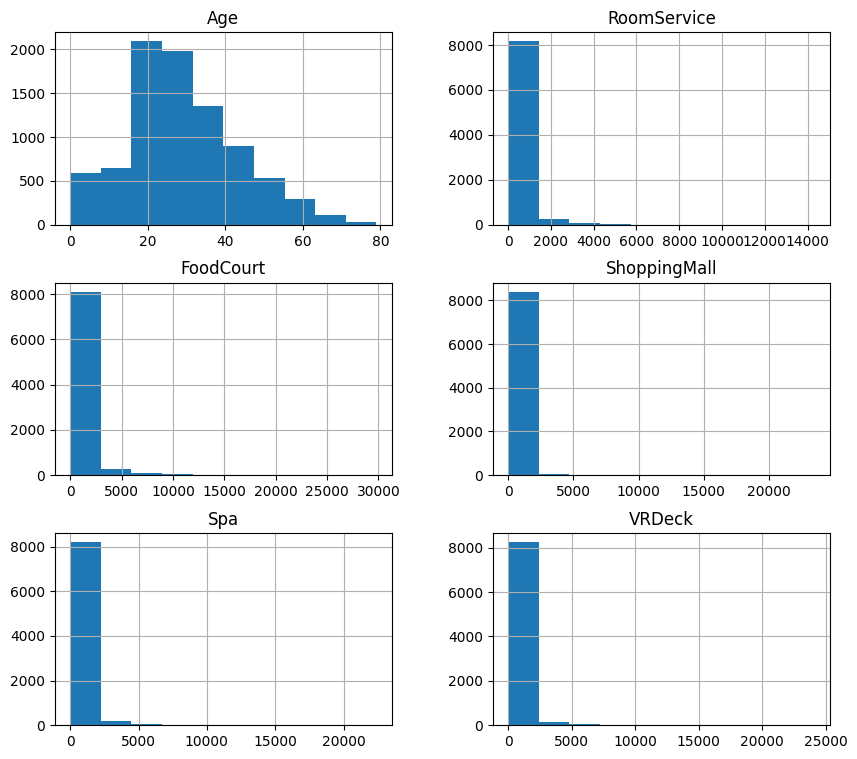

In [ ]:
train_data.hist(figsize=(10, 9))
plt.show()

In [ ]:
#------------------------------------------------------------------------------
# 3. TRAIN 전처리
#------------------------------------------------------------------------------

# 결측치 처리 - 불리언형은 0, 범주형은 최빈값, 수치형은 중앙값 사용
train_data['CryoSleep'] = train_data['CryoSleep'].fillna(0)
train_data['VIP'] = train_data['VIP'].fillna(0)
train_data['Cabin'] = train_data['Cabin'].fillna(train_data['Cabin'].mode()[0])
train_data['HomePlanet'] = train_data['HomePlanet'].fillna(train_data['HomePlanet'].mode()[0])
train_data['Destination'] = train_data['Destination'].fillna(train_data['Destination'].mode()[0])
train_data['ShoppingMall'] = train_data['ShoppingMall'].fillna(train_data['ShoppingMall'].median())
train_data['VRDeck'] = train_data['VRDeck'].fillna(train_data['VRDeck'].median())
train_data['FoodCourt'] = train_data['FoodCourt'].fillna(train_data['FoodCourt'].median())
train_data['Spa'] = train_data['Spa'].fillna(train_data['Spa'].median())
train_data['RoomService'] = train_data['RoomService'].fillna(train_data['RoomService'].median())
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

# Age 구간화 - 연속형 Age를 10세 단위로 범주화 (0,10,20,...,70)
train_data.loc[(train_data['Age'] >= 0) & (train_data['Age'] < 10), 'Age'] = 0
train_data.loc[(train_data['Age'] >= 10) & (train_data['Age'] < 20), 'Age'] = 10
train_data.loc[(train_data['Age'] >= 20) & (train_data['Age'] < 30), 'Age'] = 20
train_data.loc[(train_data['Age'] >= 30) & (train_data['Age'] < 40), 'Age'] = 30
train_data.loc[(train_data['Age'] >= 40) & (train_data['Age'] < 50), 'Age'] = 40
train_data.loc[(train_data['Age'] >= 50) & (train_data['Age'] < 60), 'Age'] = 50
train_data.loc[(train_data['Age'] >= 60) & (train_data['Age'] < 70), 'Age'] = 60
train_data.loc[(train_data['Age'] >= 70) & (train_data['Age'] < 80), 'Age'] = 70

# Cabin 분할 - Cabin: "A/5/S" -> Cab_1(deck:"A"), Cab_2(number:5), Cab_3(side:"S")
cab = train_data["Cabin"].apply(lambda x: x.split("/"))
train_data["Cab_1"] = cab.apply(lambda x: x[0])
train_data["Cab_3"] = cab.apply(lambda x: x[2])
train_data["Cab_2"] = cab.apply(lambda x: float(x[1]))

# 불필요 컬럼 drop -> PassengerId, Name, Cabin(분할 후) 삭제
train_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
train_data["VIP"] = train_data["VIP"].astype(int)
train_data["CryoSleep"] = train_data["CryoSleep"].astype(int)

# 원-핫 인코딩 -> 범주형 변수들을 더미변수로 변환
encoding_train_data = pd.get_dummies(train_data)


4. TEST 전처리 - TRAIN과 동일하게 처리한다

In [ ]:
#------------------------------------------------------------------------------
# 4. TEST 전처리 - TRAIN과 동일하게 처리한다.
#------------------------------------------------------------------------------

# 결측치 처리
test_data['CryoSleep'] = test_data['CryoSleep'].fillna(0)
test_data['VIP'] = test_data['VIP'].fillna(0)
test_data['Cabin'] = test_data['Cabin'].fillna(test_data['Cabin'].mode()[0])
test_data['HomePlanet'] = test_data['HomePlanet'].fillna(test_data['HomePlanet'].mode()[0])
test_data['Destination'] = test_data['Destination'].fillna(test_data['Destination'].mode()[0])
test_data['ShoppingMall'] = test_data['ShoppingMall'].fillna(test_data['ShoppingMall'].median())
test_data['VRDeck'] = test_data['VRDeck'].fillna(test_data['VRDeck'].median())
test_data['FoodCourt'] = test_data['FoodCourt'].fillna(test_data['FoodCourt'].median())
test_data['Spa'] = test_data['Spa'].fillna(test_data['Spa'].median())
test_data['RoomService'] = test_data['RoomService'].fillna(test_data['RoomService'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

# Age 구간화
test_data.loc[(test_data['Age'] >= 0) & (test_data['Age'] < 10), 'Age'] = 0
test_data.loc[(test_data['Age'] >= 10) & (test_data['Age'] < 20), 'Age'] = 10
test_data.loc[(test_data['Age'] >= 20) & (test_data['Age'] < 30), 'Age'] = 20
test_data.loc[(test_data['Age'] >= 30) & (test_data['Age'] < 40), 'Age'] = 30
test_data.loc[(test_data['Age'] >= 40) & (test_data['Age'] < 50), 'Age'] = 40
test_data.loc[(test_data['Age'] >= 50) & (test_data['Age'] < 60), 'Age'] = 50
test_data.loc[(test_data['Age'] >= 60) & (test_data['Age'] < 70), 'Age'] = 60
test_data.loc[(test_data['Age'] >= 70) & (test_data['Age'] < 80), 'Age'] = 70

# Cabin 분할
cab = test_data["Cabin"].apply(lambda x: x.split("/"))
test_data["Cab_1"] = cab.apply(lambda x: x[0])
test_data["Cab_3"] = cab.apply(lambda x: x[2])
test_data["Cab_2"] = cab.apply(lambda x: float(x[1]))

# 불필요 컬럼 drop
test_data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)
test_data["VIP"] = test_data["VIP"].astype(int)
test_data["CryoSleep"] = test_data["CryoSleep"].astype(int)

# 원-핫 인코딩
encoding_test_data = pd.get_dummies(test_data)

#------------------------------------------------------------------------------
# 5. 컬럼 맞추기
#------------------------------------------------------------------------------

# train 기준으로 test 컬럼 맞추기 - 하는 이유 확인할 것
encoding_test_data = encoding_test_data.reindex(columns=encoding_train_data.columns, fill_value=0)

# Transported 제거 (test에는 없음)
encoding_test_data = encoding_test_data.drop('Transported', axis=1, errors='ignore')

6. 모델 학습

In [ ]:
#------------------------------------------------------------------------------
# 6. 모델 학습 : 랜덤포레스트 + GridSearchCV 사용
#------------------------------------------------------------------------------
y_target = train_data['Transported']
x_data = encoding_train_data.drop('Transported', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.15, random_state=0)

# GridSearchCV
# 너무 오래 걸린다. 찾아진 최적값을 바로 적용한다.
# params = { 'n_estimators' : [50, 100, 200, 300, 400], # 트리 개수
#            'max_depth' : [4, 6, 8, 10, 12, 16], # 트리 깊이
#            'min_samples_leaf' : [4, 8, 12, 16, 20], # 리프노드 최소 샘플
#            'min_samples_split' : [4, 8, 12, 16, 20] # 분할 최소 샘플
# }
params = {
    'n_estimators' : [200], # 트리 개수
    'max_depth' : [16], # 트리 깊이
    'min_samples_leaf' : [8], # 리프노드 최소 샘플
    'min_samples_split' : [4] # 분할 최소 샘플
}

grid_re_clf = RandomForestClassifier(random_state=5, n_jobs=-1)
grid_cv = GridSearchCV(grid_re_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터: {'max_depth': 16, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 200}
최고 예측 정확도: 0.8015


7. 최종 모델 학습

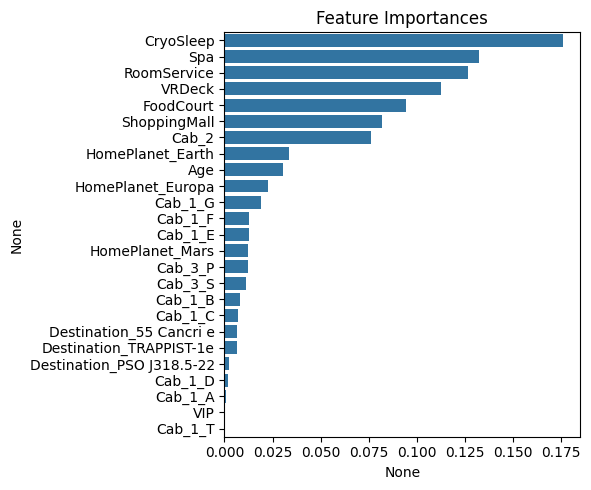

In [ ]:
# 최종 모델 학습
model = RandomForestClassifier(**grid_cv.best_params_, random_state=5, n_jobs=-1)
model.fit(x_train, y_train)

#------------------------------------------------------------------------------
#  7. FEATURE IMPORTANCE 확인 - 학습된 모델의 피처 중요도를 바 차트로 확인한다.
#------------------------------------------------------------------------------
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_sort = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(6,5))
plt.title('Feature Importances')
sns.barplot(x=ftr_sort, y=ftr_sort.index)
plt.tight_layout()
plt.show()

 8. 예측 & 제출

In [ ]:
#------------------------------------------------------------------------------
# 8. 예측 & 제출
#------------------------------------------------------------------------------
test_x_data = encoding_test_data
rf_predict = model.predict(test_x_data)

sample_submission['Transported'] = rf_predict
sample_submission.to_csv(f'{DATA_PATH}/submission_1.csv', index=False)
print(sample_submission.head())
print("completed...")

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False
completed...
